# Week 4 - Regression and Model Evaluation

## Aims

By the end of this notebook you will be able to 

>* fit a linear regression
>* understand the basics of polynomial regression
>* understand how to evaluate and compare models and select tuning parameters with training, validation, and testing.

1. [Problem Definition and Setup](#setup)

2. [Exploratory Data Analysis](#EDA)

3. [Least Squares Estimation](#RBH)

4. [Regression using scikit-Learn](#RSKL)

5. [Polynomial Regression](#polyreg)

During workshops, you will complete the worksheets together in teams of 2-3, using **pair programming**. From this week onwards, the worksheets will no longer contain cues to switch roles between driver and navigator; this should occur approximately every 15 minutes and should be more natural after the first weeks. When completing worksheets:

>- You will have tasks tagged by (CORE) and (EXTRA). 
>- Your primary aim is to complete the (CORE) components during the WS session, afterwards you can try to complete the (EXTRA) tasks for your self-learning process. 

Instructions for submitting your workshops can be found at the end of worksheet. As a reminder, you must submit a pdf of your notebook on Learn by 16:00 PM on the Friday of the week the workshop was given.

---

# Problem Definition and Setup <a id='setup'></a>

## Packages

First, let's load the packages you wil need for this workshop.

In [3]:
# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules and some other will be added later
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold

In [4]:
# Plotting defaults for all Figures below
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

## User Defined Helper Functions

Below are two helper functions we will be using in this workshop. You can create your own if you think it is useful or simply use already available functions within `sklearn`.  

- `get_coefs()`: Simple function that extracts both the intercept and coefficients from the model in the pipeline and then concatenates them.
- `model_fit()`: Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values with plotting as add-on.

Feel free to also modify the functions based on your needs. 

In [5]:
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

In [6]:
def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Actual vs Fitted plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted vs Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model (MSE, RMSE, Rsqr) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return MSE, RMSE, Rsqr

## Data 

To begin, we will examine `insurance.csv` data set on the medical costs which comes from the [Medical Cost Personal dataset](https://www.kaggle.com/datasets/mirichoi0218/insurance). Our goal is to model the yearly medical charges of an individual using some combination of the other features in the data. The included columns are as follows:

* `charges` - yearly medical charges in USD
* `age` - the individuals age
* `sex` - the individuals sex, either `"male"` or `"female"`
* `bmi` - the body mass index of the individual
* `children` - the number of dependent children the individual has
* `smoker` - a factor with levels `"yes"`, the individual is a smoker and `"no"`, the individual is not a smoker

We read the data into python using pandas.


In [7]:
df_insurance = pd.read_csv("mlp_week04.csv")
df_insurance.head()

,age,sex,bmi,children,smoker,charges
0,19,female,27.900,0,yes,16884.92400
1,18,male,33.770,1,no,1725.55230
2,28,male,33.000,3,no,4449.46200
3,33,male,22.705,0,no,21984.47061
4,32,male,28.880,0,no,3866.85520


# Exploratory Data Analysis <a id='eda'></a>

Before modelling, we will start with EDA to gain an understanding of the data, through descriptive statistics and visualizations. 

### 🚩 Exercise 1 (CORE)

a) Examine the data structure and look at the descriptive statistics. What are the types of variables in the data set? 

b) Create a pairs plot of the data (make sure to include the `smoker` column), describe any relationships you observe in the data. To better visualize the relationship between `children` and `charges`, create a violin plot (since `children` only takes a small number of integer values, many points are overlaid in the scatterplot and making visualization difficult).


<details><summary><b><u>Hint</b></u></summary>
    
- <code>.describe()</code> can be used to create summary descriptive statistics on a pandas dataframe.
- You can use a <code>sns.pairplot</code> and <code>sns.violinplot</code> with the hue argument
    
</details>

In [9]:
# Part a
df_insurance.describe(include='all')


,age,sex,bmi,children,smoker,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338.000000
unique,NaN,2,NaN,NaN,2,NaN
top,NaN,male,NaN,NaN,no,NaN
freq,NaN,676,NaN,NaN,1064,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,16639.912515


As seen in the data above, there are 1338 rows with 6 columns: 

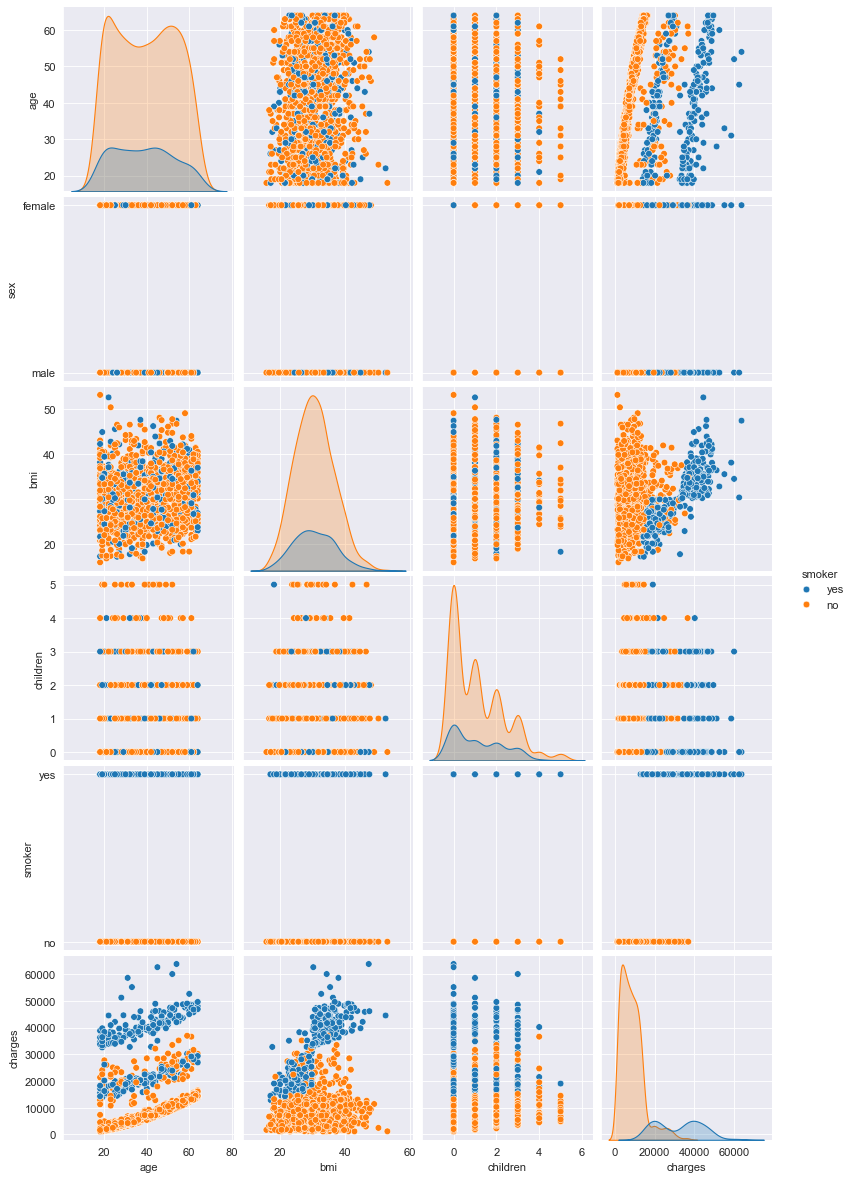

In [34]:
# Part b
columns = df_insurance.columns.values.tolist()

sns.pairplot(df_insurance, y_vars = columns,  hue = 'smoker')




<Axes: xlabel='children', ylabel='charges'>

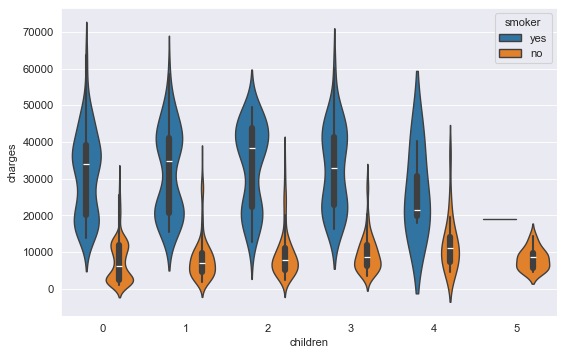

In [28]:
sns.violinplot(df_insurance, x = df_insurance['children'], y = df_insurance['charges'], hue = 'smoker' )

## Creating a Train-Test Set <a id='gen'></a>

Before modelling, we will first split the data into the train and test sets. This ensures that that we do not violate one of the golden rules of machine learning: never use the test set for training. As EDA can help guide the choice and form of model, we also may want to split the data before EDA, to avoid peeking at the test data too much during this phase. However, in practice, we may need to investigate the entire data during EDA to get a better idea on how to handle issues such as missingness, categorical data (and rare categories), incorrect data, etc.      

There are lots of ways of creating a test set. We will use a helpful function from `sklearn.model_selection` called `train_test_split`. You can have a look at the documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html. Note that `train_test_split` defaults to randomly sampling the data to split it into training and validation/test sets, that is, the default value is `shuffle=True`  

For reproducibility, we first fix the value in the numpy random seed about the state of randomness. This ensures that, every step including randomness, will produce the same output if we re-run the code or if someone else wants to reproduce our results (e.g. produce the same train-test split).

In `sklearn`, the suggestion to control randomness across multiple consecutive executions is as follows: 

- In order to obtain reproducible (i.e. constant) results across multiple program executions, we need to remove all uses of `random_state=None`, which is the default.

- Declare your own `rng` variable (random number generator) at the top of the program, and pass it down to any object that accepts a `random_state` parameter. You can check some details from here; https://numpy.org/doc/1.16/reference/generated/numpy.random.RandomState.html

Thus, our first step before splitting the data is to define our `rng` variable.

In [29]:
# To make this notebook's output identical at every run
rng = np.random.seed(0)
# might be good for our course
# np.random.seed(11205) 

### 🚩 Exercise 2 (CORE)

Use `train_test_split()` to split the data randomly into training (70%) and test (30%) sets. The `training set` will contain our test data, which you should call `X_train` and `y_train`. The `test set` will contain our testing data, which you should call `X_test` and `y_test`. Don't forget to pass in the `rng` variable to `random_state`.

Can you think on a scenario where not shuffling would be a good idea? What about when we would want to shuffle our data?

In [31]:
from sklearn.model_selection import train_test_split

# First split off features and targets
X = df_insurance.drop('charges', axis = 1) # Set of features
y = df_insurance['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=rng)



We don't want to shuffle the data when it's order specific - for instance time series or sequences.

# Least Squares Estimation <a id='RBH'></a>

Consider a linear regression model for `charges` using `bmi` and `smoker` as features in our model. Without sklearn functionalities, let's compute and visualize the least squares estimates.

### 🚩 Exercise 3 (CORE)

Create a scatter plot using the `insurance_df` data frame. Describe any apparent relationship between `charges` and `bmi` (including the `smoker` attribute) and comment on the difference between smokers and non-smokers.

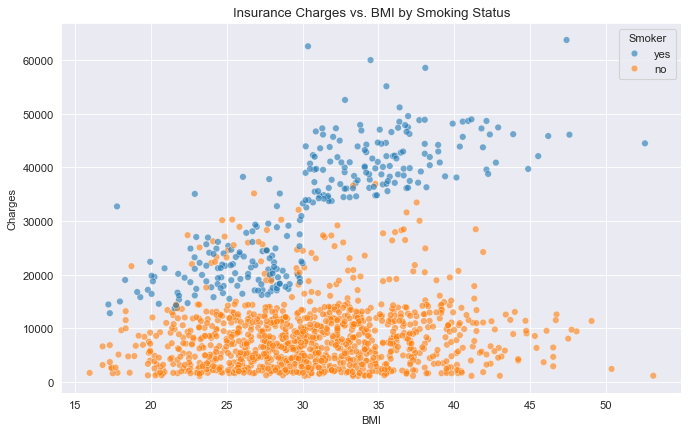

In [35]:
# Create a scatter plot with 'bmi' as x-axis and 'charges' as y-axis
# Use the 'smoker' column to color the points
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
sns.scatterplot(data=df_insurance, x='bmi', y='charges', hue='smoker', alpha=0.6)

plt.title('Insurance Charges vs. BMI by Smoking Status')  # Add a title to the plot
plt.xlabel('BMI')  # Label x-axis
plt.ylabel('Charges')  # Label y-axis
plt.legend(title='Smoker')  # Add legend with title
plt.show()


### 🚩 Exercise 4 (CORE)

Now, let's compute the least square estimates.

a) First construct the design matrix as an `np.array`. Recall that we need to include a column of ones to allow a non-zero intercept. You will also need to convert the response `y_train` to an `np.array`.

b) Compute the least squares estimates $\hat{\boldsymbol{w}}$, using the expression from lectures and the `solve` function from `numpy.linalg`.

c) What is the intercept for non-smokers and what is the intercept for smokers?

<details><summary><b><u>Hint</b></u></summary>
    
Your design matrix should have three columns, with the last column indicating if the individual is a smoker:
    $$ 
x_{n,3} = 
\begin{cases}
1 & \text {if individual $n$ is a smoker} \\
0 & \text {if individual $n$ is not a smoker}
\end{cases}
$$
You can create this feature in different ways, for example simply using `X_train.smoker == "yes"` (or using `pd.get_dummies` or `OneHotEncoder`).
    
</details>

In [104]:
# Part a

X_train_mat = np.ones((len(X_train), 4))
X_train_mat[:, 1] = X_train['bmi']
X_train_mat[:, 2] = X_train.smoker == "yes"
X_train_mat[:, 3] = X_train.smoker == "no"



In [105]:
# Part b
from numpy.linalg import solve

X_transpose = X_train_mat.transpose()
X_product = np.dot(X_transpose, X_train_mat)
X_product_inv = np.linalg.inv(X_product)
X_inv_trans_prod = np.dot(X_product_inv, X_transpose)

final = np.dot(X_inv_trans_prod, y)
final


array([-3732.10886089,   391.56622408, 42748.31287616, 15269.64090192])

In [99]:
# Part c
print(final[0])
print(final[0]+final[2])


-3732.108860888674
39016.20401527343


### 🚩 Exercise 5 (CORE)

a) Compute the fitted values from this model by calculating $\hat{\mathbf{y}} = \boldsymbol{X} \hat{\boldsymbol{w}}$. 

b) Redraw your scatter plot of `bmi` against `charges`, colored by `smoker` from Exercise 3, and overlay a line plot of the fitted values (fitted regression line). Comment on the results and any potential feature engineering steps that could help to improve the model.  

In [100]:
# Part a: Compute fitted values
y_hat = np.dot(X_train_mat, final)
y_hat

array([22585.57305353, 24380.90419095, 29843.2530169 , 21878.79601906,
       22287.98272323, 23206.2055187 , 51738.19063572, 24817.5005308 ,
       25665.24140594, 26742.04852217, 25633.91610801, 21172.01898459,
       53778.25066319, 25164.03663911, 26528.64493004, 23683.91631208,
       24222.3198702 , 25449.87998269, 19163.28425505, 27272.6207558 ,
       26828.19309147, 25708.31369059, 18716.89875959, 51980.96169465,
       23253.19346559, 50919.81722739, 46493.16106413, 27345.06050726,
       22399.57909709, 59604.75607754, 23726.98859673, 21730.00085391,
       29067.95189322, 46898.43210606, 52486.08212372, 49956.56431615,
       22250.78393194, 51849.78700959, 22031.50684645, 49525.84146965,
       25040.69327853, 52603.55199094, 24459.21743577, 26565.84372133,
       23813.13316603, 51663.79305315, 28723.37361603, 21052.59128625,
       19349.27821149, 23106.35613156, 22213.58514065, 25561.47635656,
       28648.97603345, 21961.02492612, 22148.97671368, 23985.42230463,
      

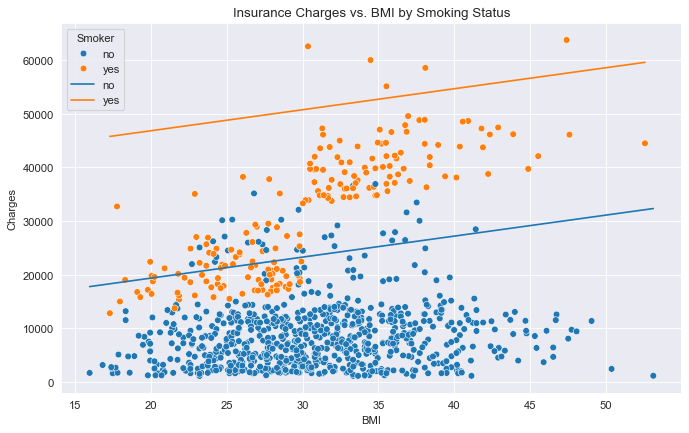

In [101]:
# Part b: Plot fitted values
plt.figure(figsize=(10, 6))  # Set the figure size for better readability

bmi = X_train['bmi']
sns.scatterplot(x = bmi, y = y_train, hue = X_train['smoker'])
sns.lineplot(x = bmi, y = y_hat, hue = X_train['smoker'])

plt.title('Insurance Charges vs. BMI by Smoking Status')  # Add a title to the plot
plt.xlabel('BMI')  # Label x-axis
plt.ylabel('Charges')  # Label y-axis
plt.legend(title='Smoker')  # Add legend with title
plt.show()

## Residuals

A useful tool for evaluating a model is to examine the residuals of that model. For any standard regression model,  the residual for observation $n$ is defined as $y_n - \hat{y}_n$ where $\hat{y}_n$ is the model's fiited value for observation $n$. 

Studying the properties of the residuals is important for assessing the quality of the fitted regression model. This scatterplot (fitted vs residuals) gives us more intuition about the model performance. Briefly, 

>- If the normal linear model assumption is true then the residuals should be randomly scattered around zero with no discernible clustering or pattern with respect to the fitted values. 
>- Furthermore, this plot can be useful to check the constant variance (homoscedastic) assumption to see whether the range of the scatter of points is consistent over the range of fitted values.

### 🚩 Exercise 6 (CORE)

a) Calculate the residuals and create a residual plot (scatter plot of fitted vs residuals) for this model and color by smoker. Comment on quality of the model based on this plot.

b) Compute the $R^2$ value for this model and comment on its value (recall from lectures that $R^2$ is 1 minus the sum of the squared residuals divided by the sum of squared differences between $\mathbf{y}$ and its mean).

<Axes: ylabel='charges'>

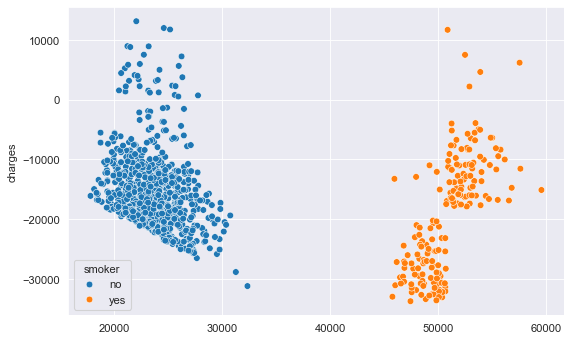

In [102]:
# Part a
residual = y_train - y_hat

sns.scatterplot(x = y_hat, y = residual, hue = X_train['smoker'] )


In [103]:
# Part b
sum_squared_residuals = np.sum(np.square(residual))
mean_y = np.mean(y_train)
sum_of_sq_diff = np.sum(np.square(y_train - mean_y))
print(1 - sum_squared_residuals/sum_of_sq_diff)


-1.1872746795611167


Approximately 63% variability in the data

## Rank deficiency

### 🚩 Exercise 7 (CORE)

Now lets consider the model where we naively include both dummies variables for smokers and non-smokers as well as an intercept column in our model matrix. What happens when you try to compute the least squares estimate in this case? What is the rank of the design matrix? You can use `numpy.linalg.matrix_rank` to compute the rank. 

In [ ]:
# Compute the least squares estimate when both dummy variable are included
#Edited excercise above 
X_train_mat = np.ones((len(X_train), 4))
X_train_mat[:, 1] = X_train['bmi']
X_train_mat[:, 2] = X_train.smoker == "yes"
X_train_mat[:, 3] = X_train.smoker == "no"

y_train_mat = y_train.to_numpy()

X_transpose = X_train_mat.transpose()
X_product = np.dot(X_transpose, X_train_mat)
X_product_inv = np.linalg.inv(X_product)
X_inv_trans_prod = np.dot(X_product_inv, X_transpose)

final = np.dot(X_inv_trans_prod, y)

In [ ]:
# Compute the rank of the design matrix


---
# Regression using scikit-Learn <a id='RSKL'></a>

Linear regression is available in **scikit-learn** (**sklearn**) through `LinearRegression` from the `linear_model` submodule. You can browse through the documentation and examples [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Let's start by importing it.

In [ ]:
from sklearn.linear_model import LinearRegression

In general sklearn's models are implemented by first creating a model object, and then using that object to fit your data. As such, we will now create a linear regression model object `lr` and use it to fit our data. Once this object is created we use the `fit` method to obtain a model object fitted to our data. 

Note that by default an intercept is included in the model. So, we do NOT need to add a column of ones to our design matrix.

In [ ]:
lr = LinearRegression()

X_train_ = np.c_[
    X_train.bmi,
    X_train.smoker == "yes"
]

lr_fit = lr.fit(
    X = X_train_, 
    y = y_train
)

This model object then has various useful methods and attributes, including `intercept_` and `coef_` which contain our estimates for $\boldsymbol{w}$. 

Note that if `fit_intercept=False` and a column of ones is included in the design matrix, then both the intercept and coefficient will be stored in `coef_`.

In [ ]:
w_0 = lr_fit.intercept_  # Intercept term of the fitted model
w_1 = lr_fit.coef_ 

w = np.concatenate([[w_0], w_1])
print(w)

# Or use or helper function to combine the intercept and coefficient into a single array
get_coefs(lr_fit)

The model fit objects also provide additional useful methods for evaluating the model $R^2$ (`score`) and calculating predictions (`predict`). Let's use the latter to compute the fitted values and predictions, as well as some metrics to evaluate the performance on the test data.

In [ ]:
# Fitted values
y_fit = lr_fit.predict(X_train_)

# Predicted values
X_test_ = np.c_[
    X_test.bmi,
    X_test.smoker == "yes"
]
y_pred = lr_fit.predict(X_test_)

# The mean squared error of the training set 
print("Training Mean squared error: %.3f" % mean_squared_error(y_train, y_fit))
# The coefficient of determination of the training set 
print("Training R squared: %.3f" % r2_score(y_train, y_fit))

# The mean squared error of the test set 
print("Test Mean squared error: %.3f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination of the test set 
print("Test R squared: %.3f" % r2_score(y_test, y_pred))

# Another way for R2 calculation
print(lr.score(X_train_, y_train)) 

In [ ]:
# If we use the pre-defined function
model_fit(lr_fit, X_train_, y_train, plot = True)

### 🚩 Exercise 8 (CORE)

Consider a pipeline for a regression model, using sklearn functionalities 

- including `bmi` and `age` as numerical values and smoker condition as a categorical value

- Apply encoding for the `smoker` variable within the pipeline

- Fit a model including these variables and calculate performance metrics similar to above ($R^2$, and MSE / RMSE). How does this model compare to previous one?

Note that using the option `OneHotEncoder(drop=np.array(['Reference Category']))`, we can specify the which category to drop (the reference category) by replacing `'Reference Category'` with the desired category.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Create ML pipeline 


In [ ]:
# Fit the model and calculate metrics


--------

# Polynomial Regression<a id='polyreg'></a>


## Polynomial features in sklearn

sklearn has a built in function called `PolynomialFeatures` which can be used to simplify the process of including polynomial features in a model. You can browse the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html). This function is included in the *preprocessing* module of sklearn, as with other python functions we can import it as follows.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

Construction and use of this is similar to what we have already seen with other transformers; we construct a PolynomialFeatures object in which we set basic options (e.g. the degree of the polynomial) and then apply the transformation to our data by calling `fit_transform`. This will generate a new model matrix which includes the polynomial features up to the degree we have specified.

Run the following code for a simple illustration:

In [ ]:
x = np.array([1, 2, 3, 4])
PolynomialFeatures(degree = 2).fit_transform(x.reshape(-1,1))

Note that when we use this transformation, we get **all of the polynomial transformations of x from 0 to degree**. 

In this case, the **0 degree column** is equivalent to **the intercept column**. If we do not want to include this we can construct `PolynomialFeatures` with the option `include_bias=False`.

In [ ]:
PolynomialFeatures(degree = 2, include_bias=False).fit_transform(x.reshape(-1,1))

We can also use `PolynomialFeatures` to add only interaction terms, through the option `interaction_only=True`. As an illustration run the following code:

In [ ]:
x = np.array([[1, 2, 3, 4],[0,0,1,1]]).T
PolynomialFeatures(interaction_only=True,include_bias=False).fit_transform(x)

## Interactions

Now, let's create a pipeline that:

- includes `bmi` as a numerical variable and smoker condition as a categorical variable

- applies encoding for the `smoker` variable

- uses `PolynomialFeatures` to include an **interaction** between `smoker` and `bmi`

In [ ]:
# Create Pipeline for model that includes interactions
cat_pre = OneHotEncoder(drop=np.array(['no']))

pf = PolynomialFeatures(interaction_only=True,include_bias=False)

# Overall ML pipeline
reg_pipe_2 = Pipeline([
    ("pre_processing", ColumnTransformer([
        ("cat_pre", cat_pre, [4]), # Applied to smoker
        ("num_pre", 'passthrough', [2])])), # Applied to bmi
    ("interact", pf),
    ("model", LinearRegression())
])

In [ ]:
#Train the model
lr3_fit = reg_pipe_2.fit(X_train,y_train)

Note that:

- We have set `include_bias=False` as the intercept is included in linear regression by default

- The returned object is a `Pipeline` object so it will not provide direct access to step properties, such as the coefficients for the regression model.

- If we want access to the attributes or methods of a particular step we need to first access that step using either its name or position.

In [ ]:
print(reg_pipe_2.named_steps['model'].coef_)

In [ ]:
print(reg_pipe_2.steps[2][1].intercept_) # second subset is necessary here because 
                                       # each step is a tuple of a name and the 
                                       # model / transform object 

Alternatively, you can use the `get_coefs` helper function supplied.

We can also extract the **names of the features** using the method `get_feature_names_out()` of the transfomers. Here we need to first extract the names from the first feature engineering step and then pass them to the second step of the pipeline.

In [ ]:
# Extract the names of the features
names_fe1 = reg_pipe_2['pre_processing'].get_feature_names_out()
#print(names_fe1)
print(reg_pipe_2['interact'].get_feature_names_out(names_fe1))

### 🚩 Exercise 9 (CORE)

For the model trained above (`lr3_fit`):

a) What is the intercept and slope for non-smokers and what is the intercept and slope for smokers?

b) Compute the fitted values by calling `predict`. Draw the scatter plot of bmi against charges, colored by smoker (from Exercise 3), and overlay a line plot of the fitted values (fitted regression lines).

c) How does this model compare to the previous ones?

In [ ]:
#Part a


In [ ]:
#Part b


In [ ]:
# Part c


## Nonlinearity

Now, let's explore including nonlinearity into the model through a polynomial basis function expansions of `bmi`.

### 🚩 Exercise 10 (CORE)

First, suppose you naively apply a polynomial basis function expansion to the feature matrix containing `bmi` and `smoker`: 

- Run the code below to first create the feature matrix (we standardize `bmi` to simply help with visualization). 

- Next, create the transformed feature matrix using `PolynomialFeatures` assuming `degree=2`. Print out the first 20 rows of this matrix. 

- What are the number of features and what does each column represent? Why should we **NOT** use this naive polynomial basis function expansion?

<br><br>
<details><summary><b><u>Hint</b></u></summary>
    
- Try printing out the names of each feature with the method `get_feature_names_out(['bmi','smoker'])` on your fitted  `PolynomialFeatures`object.
    
</details>

In [ ]:
# Create a matrix containing bmi and smoker (note we standardize bmi here, simply to help avoid
# printing very large numbers in the exercise)

from sklearn.preprocessing import StandardScaler

bmi_ss = StandardScaler().fit_transform(np.asarray(X_train.bmi).reshape(-1,1))

X_ = np.c_[
    X_train.smoker == "yes",
    bmi_ss
]

In [ ]:
# Create transformed feature matrix


### 🚩 Exercise 11 (CORE)

Now, let's create a model that allows nonlinearity of `bmi` through polynomial basis function expansion of degree 3 (with no interactions for ease of exposition). 

Create a new pipeline to construct this model. Train this model and then plot the fitted regression line and compute the performance metrics.

In [ ]:
# Create Pipeline for model that includes polynomial expansion of bmi


In [ ]:
# Train and compute and plot fitted values


## Choosing the Order of the Polynomial

How can we choose the order of the polynomial? 

In lecture, we discussed how chosing the degree to be too large can cause over fittting. When we over fit a polynomial regression model, the MSE for the training data will appear to be low which might indicate that the model is a good fit. But, as a result of over fitting, the MSE for the predictions of the unseen test data may begin to increase. However, we can **NOT** use the test to determine the order of the polynomial, so in the following, we explore using cross-validation to do so.

### 🚩 Exercise 12 (EXTRA)

First, let's compute and plot the **training and test MSE** over a range of degree values. What do you notice about the fit as we increase the polynomial degree? Which degree seems better regarding the changes on training and testing MSE values?

### Tunning with GridSearchCV

If we wish to test over a specific set of parameter values using cross validation we can use the `GridSearchCV` function from the `model_selection` submodule. In this setting, the hyperparamer is actually the degree of the polynomial that we are investigating. 

This argument is a dictionary containing parameters names as keys and lists of parameter settings to try as values. Since we are using a pipeline, our parameter name will be the name of the pipeline step, `pre_processing`, followed by `__`, (then, the name of next step if applicable, e.g. `poly__` since we are using `ColumnTransformer`), and then the parameter name, `degree`. So for our pipeline the parameter is named `pre_processing_poly__degree`. If you want to list the names of all available parameters you can call the `get_params()` method on the model object, e.g. `polyreg_pipe.get_params()` here.

In [ ]:
cat_pre = OneHotEncoder(drop=np.array(['no']))

pf = PolynomialFeatures(include_bias=False)

# Overall ML pipeline
polyreg_pipe = Pipeline([
    ("pre_processing", ColumnTransformer([
        ("cat_pre", cat_pre, [4]), # Applied to smoker
        ("poly", pf, [2])])), # Applied to bmi
    ("model", LinearRegression())])

# Parameters for grid search
parameters = {
    'pre_processing__poly__degree': np.arange(1,10,1)
}

kf = KFold(n_splits = 5, shuffle = True, random_state=rng)

grid_search = GridSearchCV(polyreg_pipe, parameters, cv = kf, scoring = 'neg_mean_squared_error', return_train_score=True).fit(X_train, y_train)

In [ ]:
#polyreg_pipe.get_params()

The above code goes through the process of fitting all $5 \times 9$ models as well as storing and ranking the results for the requested scoring metric(s). Note that here we have used `neg_mean_squared_error` as our scoring metric which returns the **negative of the mean squared error**. For more on metrics of regression models, please see: https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

- As the name implies this returns the negative of the usual fit metric, this is because sklearn expects to always optimize for the maximum of a score and the model with the largest negative MSE will therefore be the "best". 

- In this workshop we have used MSE as a metric for testing our models. This metric is entirely equivalent to the root mean squared error for purposes of ranking / ordering models (as the square root is a monotonic transformation). 
- Sometimes the RMSE is prefered as it is more interpretable, because it has the same units as $y$.

Once all of the submodels are fit, we can determine the optimal hyperparameter value by accessing the object's `best_*` attributes,

In [ ]:
print("best index: ", grid_search.best_index_)
print("best param: ", grid_search.best_params_)
print("best score: ", grid_search.best_score_)

The best estimator is stored in the `.best_estimator` attribute. By default, after this model is found, it is retrained on all training data points.

In [ ]:
grid_search.best_estimator_['model'].coef_

In [ ]:
# Compute fitted values
yhat =grid_search.predict(X_train)

# Plot fitted values
ax = sns.scatterplot(x = X_train.bmi, y = y_train, hue = X_train.smoker)
sns.lineplot(x = X_train.bmi, y = yhat, hue = X_train.smoker, ax=ax, legend = False)
ax.set(ylabel='charges')
plt.show()

The cross-validated scores are stored in the attribute `cv_results_`. This contains a number of results related to the grid search and cross-validation. We can convert it into a pandas data frame to view the results.

In [ ]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

It is also recommend to plot the CV scores. Although the grid search may report a best value for the parameter corresponding to the maximum CV score (e.g. min CV MSE), if the curve is relatively flat around the minimum, we may prefer the simpler model.

Note in this case, I have also used the option `return_train_score=True` in `GridSearchCV()`, in order to save also the training scores. As expected training MSE decreases when increasing the degree of the polynomial, but the CV MSE has more of a U-shape.

In [ ]:
degree = np.arange(1,10,1)
fig, ax = plt.subplots(figsize=(9,7), ncols=1, nrows=1)
plt.scatter(degree,-grid_search.cv_results_['mean_train_score'], color='k')
plt.plot(degree,-grid_search.cv_results_['mean_train_score'], color='k', label='Mean Train MSE')
plt.scatter(degree,-grid_search.cv_results_['mean_test_score'], color='r')
plt.plot(degree,-grid_search.cv_results_['mean_test_score'], color='r', label='CV MSE')
ax.legend()
ax.set_xlabel('degree')
ax.set_ylabel('MSE')
plt.show()

### 🚩 Exercise 13 (EXTRA)

Try an alternative model of your choice. What have you chosen and why? Are there any paramters to tune?

### Further resources

- About common pitfalls and interpreting coefficients: 

https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#

# Competing the Worksheet

At this point you have hopefully been able to complete all the CORE exercises and attempted the EXTRA ones. Now 
is a good time to check the reproducibility of this document by restarting the notebook's
kernel and rerunning all cells in order.

Before generating the PDF, please go to Edit -> Edit Notebook Metadata and change 'Student 1' and 'Student 2' in the **name** attribute to include your name.

Once that is done and you are happy with everything, you can then run the following cell 
to generate your PDF. Once generated, please submit this PDF on Learn page by 16:00 PM on the Friday of the week the workshop was given. 

In [ ]:
!jupyter nbconvert --to pdf mlp_week04.ipynb 